In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL External Data-set")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/09 11:52:17 WARN Utils: Your hostname, DESKTOP-1ML24G5 resolves to a loopback address: 127.0.1.1; using 172.30.91.59 instead (on interface eth0)
22/09/09 11:52:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/09 11:52:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [43]:
# Store data in pyspark data frame:
population_df = spark.read.option("header", True).csv('../../../data/tables/population_data.csv')

In [3]:
# Inspect data frame:
population_df.limit(5)

22/09/09 11:59:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


FID,primaryindex,state_code_2016,state_name_2016,gccsa_code_2016,gccsa_name_2016,sa4_code_2016,sa4_name_2016,sa3_code_2016,sa3_name_2016,sa2_maincode_2016,sa2_name_2016,erp_2001,erp_2002,erp_2003,erp_2004,erp_2005,erp_2006,erp_2007,erp_2008,erp_2009,erp_2010,erp_2011,erp_2012,erp_2013,erp_2014,erp_2015,erp_2016,erp_2017,erp_2018,erp_2019,erp_2020,erp_2021,erp_change_number_2020_21,erp_change_per_cent_2020_21,area_km2,pop_density_2021_people_per_km2,births_2016_17,deaths_2016_17,natural_increase_2016_17,internal_arrivals_2016_17,internal_departures_2016_17,net_internal_migration_2016_17,overseas_arrivals_2016_17,overseas_departures_2016_17,net_overseas_migration_2016_17,births_2017_18,deaths_2017_18,natural_increase_2017_18,internal_arrivals_2017_18,internal_departures_2017_18,net_internal_migration_2017_18,overseas_arrivals_2017_18,overseas_departures_2017_18,net_overseas_migration_2017_18,births_2018_19,deaths_2018_19,natural_increase_2018_19,internal_arrivals_2018_19,internal_departures_2018_19,net_internal_migration_2018_19,overseas_arrivals_2018_19,overseas_departures_2018_19,net_overseas_migration_2018_19,births_2019_20,deaths_2019_20,natural_increase_2019_20,internal_arrivals_2019_20,internal_departures_2019_20,net_internal_migration_2019_20,overseas_arrivals_2019_20,overseas_departures_2019_20,net_overseas_migration_2019_20,births_2020_21,deaths_2020_21,natural_increase_2020_21,internal_arrivals_2020_21,internal_departures_2020_21,net_internal_migration_2020_21,overseas_arrivals_2020_21,overseas_departures_2020_21,net_overseas_migration_2020_21,geom
abs_regional_popu...,1,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021007,Braidwood,2760,2811,2835,2844,2847,2965,3102,3181,3308,3429,3458,3590,3685,3762,3849,3950,4041,4145,4222,4292,4360,68,1.5843,3418.3525,1.2755,43,24,19,276,215,61,18,7,11,32,31,1,386,293,93,18,8,10,39,30,9,389,331,58,18,8,10,35,30,5,394,337,57,17,9,8,37,26,11,375,319,56,7,6,1,MULTIPOLYGON (((-...
abs_regional_popu...,2,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021008,Karabar,9129,9199,9263,9277,9209,9212,9033,8994,9030,9101,9092,9012,8848,8731,8603,8531,8484,8424,8370,8371,8374,3,0.0358,6.9825,1199.2839,119,25,94,708,896,-188,75,28,47,100,58,42,908,1051,-143,72,31,41,125,37,88,872,1051,-179,72,35,37,123,45,78,848,951,-103,65,39,26,114,41,73,871,946,-75,28,23,5,MULTIPOLYGON (((-...
abs_regional_popu...,3,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021009,Queanbeyan,9717,9513,9522,9400,9595,9682,9793,10074,10288,10584,10715,10870,11050,11199,11213,11230,11351,11441,11449,11449,11401,-48,-0.4193,4.7634,2393.4585,174,119,55,1217,1315,-98,264,100,164,191,99,92,1557,1703,-146,254,110,144,182,103,79,1494,1702,-208,259,122,137,177,122,55,1416,1564,-148,230,137,93,149,104,45,1486,1662,-176,165,82,83,MULTIPOLYGON (((-...
abs_regional_popu...,7,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10103,Snowy Mountains,101031013,Bombala,2622,2617,2590,2576,2577,2589,2567,2534,2516,2503,2484,2462,2451,2437,2428,2420,2414,2412,2423,2421,2411,-10,-0.4131,3989.3618,0.6044,24,36,-12,122,118,4,4,2,2,22,33,-11,176,169,7,4,2,2,23,20,3,150,144,6,4,2,2,26,17,9,117,130,-13,4,2,2,19,41,-22,163,152,11,2,1,1,MULTIPOLYGON (((-...
abs_regional_popu...,14,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10104,South Coast,101041020,Bega-Eden Hinterland,8429,8504,8549,8658,8741,8798,8826,8883,8993,9090,9073,9039,9014,8996,8971,8952,8928,8914,8893,8879,8996,117,1.3177,4710.207,1.9099,65,45,20,562,620,-58,23,9,14,82,52,30,758,814,-56,22,10,12,80,61,19,615,667,-52,22,10,12,82,63,19,645,686,-41,20,12,8,83,67,16,738,639,99,9,7,2,MULTIPOLYGON (((-...


In [4]:
# Select subset important attributes, ignore the rest:
cols_to_keep = ['sa2_maincode_2016', 'sa2_name_2016', 'erp_2021']
population_df = population_df.select(*cols_to_keep)

In [5]:
# Inspect subset:
population_df.limit(3)

sa2_maincode_2016,sa2_name_2016,erp_2021
101021007,Braidwood,4360
101021008,Karabar,8374
101021009,Queanbeyan,11401


In [65]:
# Check attribute types:
population_df.printSchema()

root
 |-- sa2_maincode_2016: string (nullable = true)
 |-- sa2_name_2016: string (nullable = true)
 |-- erp_2021: string (nullable = true)



In [6]:
# Assign correct attribute types from previous:
from pyspark.sql.types import IntegerType, LongType

population_df = population_df \
                .withColumn("sa2_maincode_2016", F.col("sa2_maincode_2016").cast(LongType())) \
                .withColumn("erp_2021", F.col('erp_2021').cast(IntegerType()))

population_df.printSchema()

root
 |-- sa2_maincode_2016: long (nullable = true)
 |-- sa2_name_2016: string (nullable = true)
 |-- erp_2021: integer (nullable = true)



In [7]:
# Rename columns:
population_df = population_df \
                .withColumnRenamed('sa2_name_2016', 'suburb') \
                .withColumnRenamed('erp_2021', 'estimated_region_population_2021')

In [9]:
population_df.limit(3)

sa2_maincode_2016,suburb,estimated_region_population_2021
101021007,Braidwood,4360
101021008,Karabar,8374
101021009,Queanbeyan,11401


In [10]:
initial = population_df.count()

In [20]:
filter1 = population_df.filter(F.length(F.col('sa2_maincode_2016')) == 9)
f1 = filter1.count()
filter2 = filter1.filter(F.col('estimated_region_population_2021') > 0)
f2 = filter2.count()
filter3 = filter2.filter(F.col('sa2_maincode_2016').isNotNull())
f3 = filter3.count()
filter4 = filter3.filter(F.col('suburb').isNotNull())
f4 = filter4.count()
filter5 = filter4.filter(F.col('estimated_region_population_2021').isNotNull())
f5 = filter5.count()

population_df = filter5

In [40]:
investigate = filter1.filter(F.col('estimated_region_population_2021') <= 0)
investigate


sa2_maincode_2016,suburb,estimated_region_population_2021
103031075,Wollangambe - Wol...,0
205021083,Lake King,0
123021439,Holsworthy Milita...,0
208031192,Moorabbin Airport,0
210011227,Essendon Airport,0
304041102,Mount Coot-tha,0
306021150,Lamb Range,0
308051537,South Trees,0
310041301,New Chum,0
311031315,Greenbank Militar...,0


In [15]:
print("Number of intial entries:", initial)
print("Number of entries after applying filter 1:", f1)
print("Number of entries after applying filter 2:", f2)
print("Number of entries after applying filter 3:", f3)
print("Number of entries after applying filter 4:", f4)
print("Number of entries after applying filter 5:", f5)
print("Number of entries removed:", initial-f5)

Number of intial entries: 2292
Number of entries after applying filter 1: 2292
Number of entries after applying filter 2: 2260
Number of entries after applying filter 3: 2260
Number of entries after applying filter 4: 2260
Number of entries after applying filter 5: 2260
Number of entries removed: 32


In [21]:
print(population_df.filter(F.col('sa2_maincode_2016') == "").count())
print(population_df.filter(F.col('estimated_region_population_2021') == "").count())
print(population_df.filter(F.col('suburb') == "").count())

0
0


0


In [24]:
population_df.distinct().count()

2260

In [28]:
population_df.select(F.count_distinct('sa2_maincode_2016')).show()

+---------------------------------+
|count(DISTINCT sa2_maincode_2016)|
+---------------------------------+
|                             2260|
+---------------------------------+



In [23]:
stat1 = population_df.describe('estimated_region_population_2021')
stat1

summary,estimated_region_population_2021
count,2260
mean,11388.558407079647
stddev,7765.233007489072
min,3
max,60489


In [32]:
print(population_df.filter((F.col('estimated_region_population_2021') > (11388.558407079647 + 3 * 7765.233007489072)) | \
                           (F.col('estimated_region_population_2021') < (11388.558407079647 - 3 * 7765.233007489072))).count())

18


[Text(0.5, 1.0, 'Estimated Region Population 2021 (BEFORE OUTLIER REMOVAL)')]

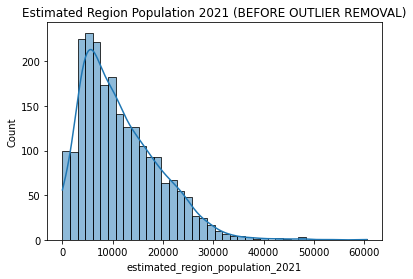

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

before_outlier_population = population_df.toPandas()
sns.histplot(before_outlier_population['estimated_region_population_2021'], kde=True, bins=40).set(title='Estimated Region Population 2021 (BEFORE OUTLIER REMOVAL)')

[Text(0.5, 1.0, 'Estimated Region Population 2021 (AFTER OUTLIER REMOVAL)')]

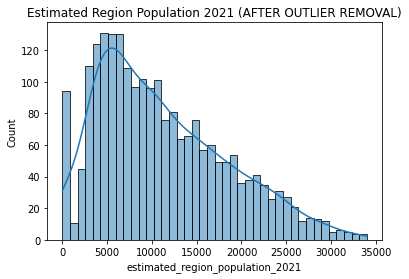

In [33]:
population_outlier_removal = population_df.filter(F.col('estimated_region_population_2021') <= (11388.558407079647 + 3 * 7765.233007489072))

after_outlier_population = population_outlier_removal.toPandas()
sns.histplot(after_outlier_population['estimated_region_population_2021'], kde=True, bins=40).set(title='Estimated Region Population 2021 (AFTER OUTLIER REMOVAL)')

In [96]:
# Function to be added to ETL:

from pyspark.sql.types import IntegerType, LongType

def population_preprocess(data):

    cols_to_keep = ['sa2_maincode_2016', 'sa2_name_2016', 'erp_2021']
    population_df = data.select(*cols_to_keep)

    population_df = population_df \
                    .withColumn("sa2_maincode_2016", F.col("sa2_maincode_2016").cast(LongType())) \
                    .withColumn("erp_2021", F.col('erp_2021').cast(IntegerType()))

    population_df = population_df \
                    .withColumnRenamed('sa2_name_2016', 'suburb') \
                    .withColumnRenamed('erp_2021', 'estimated_region_population_2021')
                    
    return population_df


In [97]:
# Testing if above function works ^^^:
test = population_preprocess(population_df)
test.limit(5)

sa2_maincode_2016,suburb,estimated_region_population_2021
101021007,Braidwood,4360
101021008,Karabar,8374
101021009,Queanbeyan,11401
101031013,Bombala,2411
101041020,Bega-Eden Hinterland,8996


In [89]:
# Check number of entries:
test.count()

2292

According to:<br>
abs.gov.au/ausstats/abs@.nsf/lookup/by%20subject/1270.0.55.001~july%202016~main%20features~statistical%20area%20level%202%20(sa2)~10014 <br>

There are 2310 distinct SA2 codes, but the population data above only has 2292. Further discussion may be necessary.